In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
import google.datalab.storage as storage
from google.datalab import Context
from google.cloud import storage as gcs
import csv
import StringIO

In [2]:
# Setting up buckets, local and YouTube 8M @ Google Storage

storageClient = gcs.Client()

project = Context.default().project_id
yt8m = 'youtube8m-ml-us-east1'

projBucket = storageClient.get_bucket(project)
yt8mBucket = storage.Bucket(yt8m)

print 'Project: ' + project
print 'YT8M: ' + yt8m

Project: nyc-dsa-proj-04
YT8M: youtube8m-ml-us-east1


In [218]:
# Reading label names from local CSV file

label_names = gcs.Blob('label_names.csv', projBucket)
label_names = label_names.download_as_string()

lbls = []
lbl = csv.reader(label_names.split('\n'), delimiter=',')
for row in lbl:
  lbls.append(row)
  
label_names = pd.DataFrame(lbls[1:], columns=lbls[0]) #.set_index('label_id')
label_names = label_names.dropna()
label_names['label_id'] = label_names.apply(lambda row: int(row['label_id']), axis=1)

numpy.int64

In [4]:
# Getting video level training files from Google Cloud Storage

video_level_globals = []
i = 0
for obj in yt8mBucket.objects(prefix='0/video_level/train/'):  # 0: video_level, 1: frame_level
    if i == 10:
        break
    
    if obj.key[-4:] != 'html':
        video_level_globals.append('gs://' + yt8m + '/' + obj.key)
        i += 1
#video_level_globals

In [98]:
# Extracting features for each video

vid_ids = []
vid_labels = []
vid_mean_rgb = []
vid_mean_audio = []

for video in video_level_globals:
  for example in tf.python_io.tf_record_iterator(video):
    tf_example = tf.train.Example.FromString(example)
    
    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    vid_labels.append(tf_example.features.feature['labels'].int64_list.value)
    vid_mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    vid_mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [104]:
# Labels per video

labels_count = []
for thisLabel in vid_labels:
  labels_count.append(len(thisLabel))

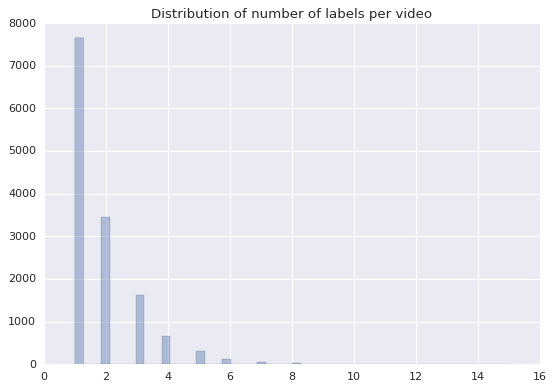

In [108]:
# Plot for labels per video

sns.distplot(labels_count, kde=False)
plt.title('Distribution of number of labels per video')

In [253]:
# Grouping by labels for total count of each label

vid_labels_flat = pd.DataFrame([item for sublist in vid_labels for item in sublist], columns=['label'])
vid_labels_flat['label_name'] = vid_labels_flat.apply(lambda row: label_names.loc[row['label'], 'label_name'] if int(row['label']) <= max(label_names['label_id']) else '', axis=1)
vid_labels_flat = pd.DataFrame(vid_labels_flat.groupby(['label', 'label_name']).size(), columns=['count']).reset_index()
vid_labels_flat = vid_labels_flat.sort_values(by='count', ascending=False)
vid_labels_flat.head()

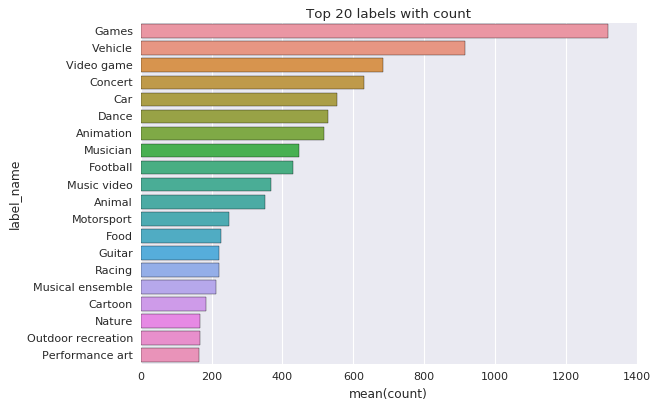

In [258]:
# Bar plot for label count

n = 20
sns.barplot(y='label_name', x='count', data=vid_labels_flat[0:n])
plt.title('Top %d labels with count' % n)

In [6]:
!gsutil cp 'YouTube 8m EDA.ipynb' project

Copying file://YouTube 8m EDA.ipynb...

Operation completed over 1 objects/61.4 KiB.                                     
